<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif False:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

TF version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [2]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_probability as tfp
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate

!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
!pip install --quiet --upgrade anisotropic-distance-transform
import fontParts
import extractor
import defcon
import adt
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")

     |████████████████████████████████| 4.6MB 12.6MB/s 
     |████████████████████████████████| 890kB 37.5MB/s 
     |████████████████████████████████| 829kB 22.0MB/s 
     |████████████████████████████████| 163kB 23.2MB/s 
     |████████████████████████████████| 235kB 43.7MB/s 
     |████████████████████████████████| 133kB 51.1MB/s 
     |████████████████████████████████| 133kB 22.9MB/s 
     |████████████████████████████████| 430kB 44.1MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 358kB 13.0MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 184kB 36.1MB/s 
✓ Dependencies imported.


In [3]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [4]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "bdghijlmnopqu" # straight letters only
#glyph_char_list = "abgjqrst"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
glyph_char_list = "abcz"

# ==== Create Font ====
factor = 1.8 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 1
sample_distance_deltas = [-1, 0, 2]
sample_distance_factors = [.8, 1., 2.0]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 5
n_b_scales = 1
n_v1_orientations = 8
n_v4_scales = 8

Box size: 143 × 289


In [5]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        min_sigma = 0.7
        max_sigma = box_width / 15
        sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_v1_scales - 1)**2 + min_sigma)
        #sigmas.append((max_sigma - min_sigma) * s / n_v1_scales + min_sigma)
    return np.array(sigmas)

print("Spatial frequency scales:", get_sigmas())

def get_v1_filter_bank(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                             [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(s, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.

        # First derivative (odd filter/up-down)
        d1_space = np.exp(-(x**2+y**2)/(2*s**2))*x/(2*pi*s**4)
        d1_relu_sum = np.sum(d1_space * (d1_space > 0))
        d1 = np.fft.fft2(np.fft.ifftshift(d1_space + 1j * np.zeros_like(d1_space)))

        # Second derivative (even filter/mexican hat):
        s2 = s * .85 # To make them about the same width
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2_relu_sum = np.sum(d2_space * (d2_space > 0))
        d2 = (d1_relu_sum / d2_relu_sum) * np.fft.fft2(np.fft.ifftshift(d2_space + 1j * np.zeros_like(d2_space)))

        return (d1 + 1j*d2) / (np.max(tf.abs(d1+1j*d2))) # Max output should be about 0.2, which leaves lots of flexibility for the HRA later

    filter_bank = np.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 20
        fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter(sigma, o)
            if display_filters:
                mx = np.max(np.abs(np.imag(np.fft.ifft2(f))))
                ax[s*2, o].imshow(np.real(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()

    return filter_bank.astype(np.complex64)

filter_bank = get_v1_filter_bank(0, display_filters=False)


def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    bdsohw_input_image = input_image[None, None, None, None, :, :]

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(padded_input, tf.zeros_like(padded_input))))

    padded_result = tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :])

    presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], [2, 3])

    return presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

Spatial frequency scales: [ 0.7         1.86041667  5.34166667 11.14375    19.26666667]


100%|██████████| 4/4 [00:00<00:00, 1330.15it/s]

  ✓ 4 glyphs rendered.



100%|██████████| 4/4 [00:00<00:00, 4884.20it/s]

  ✓ 4 glyphs measured.



100%|██████████| 4/4 [00:00<00:00, 48.68it/s]

  ✓ 4 glyphs filtered.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


local target dists


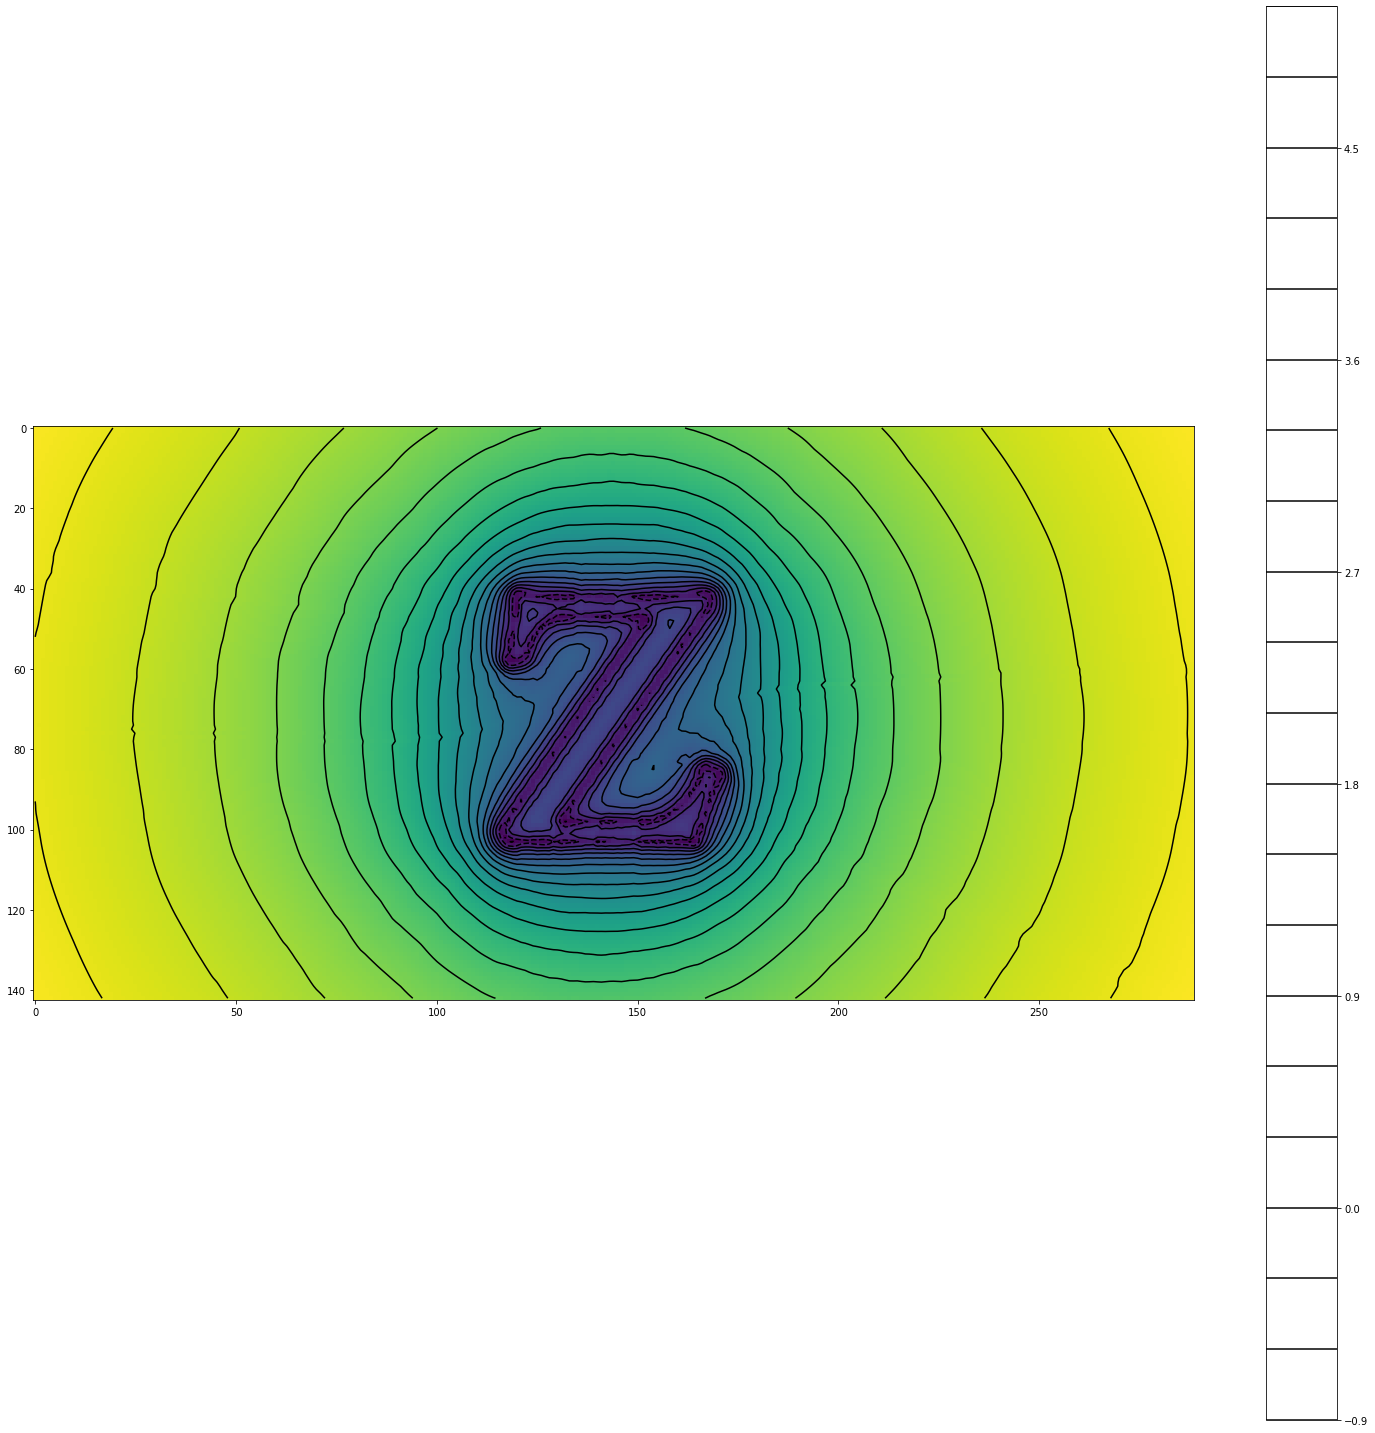

adjusted strength sum


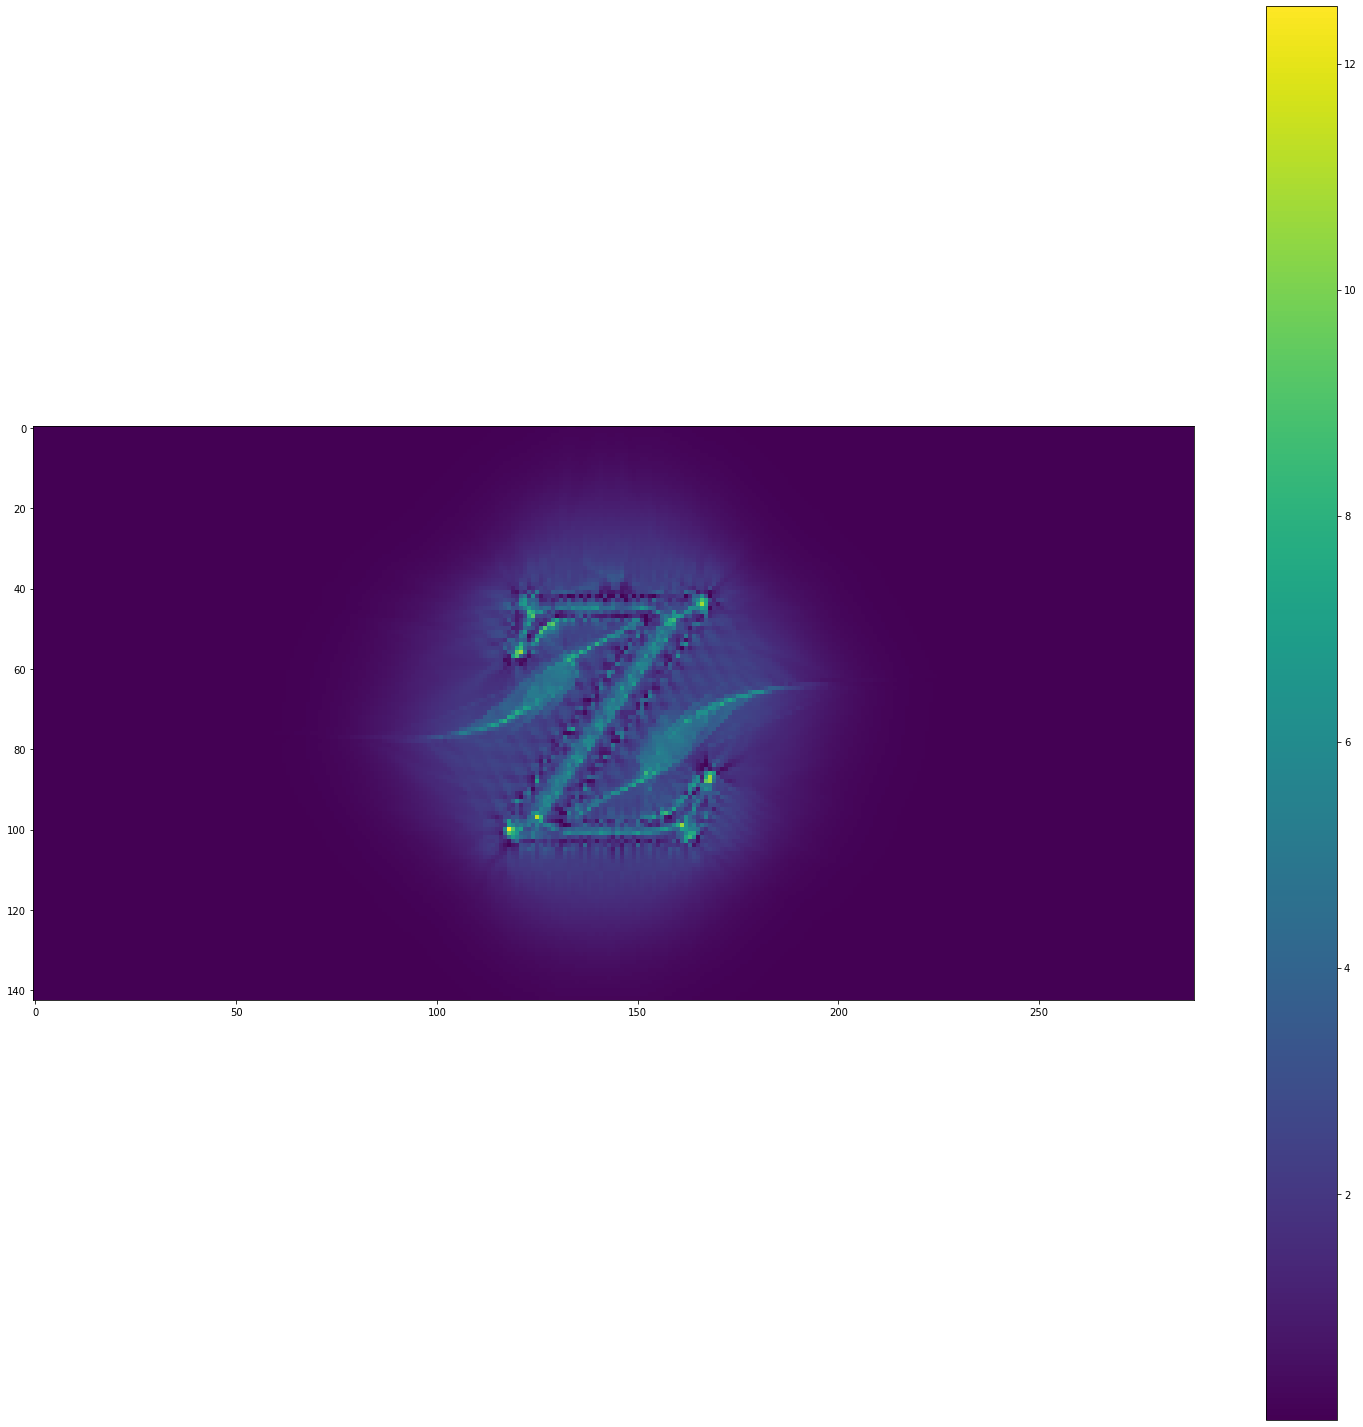

In [48]:

# 1. Render glyphs

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

def get_v1_response(glyph_image):
    """Returns a np.array of shape [n_v1_scales, n_v1_orientations, box_height, box_width] and type complex64,
    containing the local responses to the V1 filter bank (after inverse Fourier transform, i.e. in the spatial domain)."""
    with tf.device("/gpu:0"):
        filtered = apply_filter_bank(glyph_image, filter_bank)
    return filtered


glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)
glyph_v1_responses = {c: get_v1_response(glyph_images[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs filtered.", flush=True)

egl = "z"
# We now create the diagram for glyph_v1_responses["a"]
ga = np.abs(np.float32(glyph_v1_responses[egl]))

v1_scale_coeffs = np.array([0.3, 0., 0., 0., .0]) # could be extended to orientations, too!
v1_pre_log_exps = np.array([1, 1, 1, 1, 1])*10

out1 = np.zeros((n_v1_orientations*2, box_height, box_width))


for oi in range(n_v1_orientations):
    for oid in range(2):
        # we need to compute the l/r/t/b direction of the respective distance transform now!
        angle = ((pi*oi/n_v1_orientations) + (pi if oid == 1 else 0.0))
        angle_deg = angle * 180/np.pi
        rotated = rotate(ga[:, oi, :, :], angle_deg, axes=(1,2), reshape=True)
        vert_pad = int(np.round(np.abs(np.sin(2*angle)) * box_width / 2))
        hori_pad = int(np.round(np.abs(np.sin(2*angle)) * box_height / 2))

        for si in range(n_v1_scales):
            gas = rotated[si, :, :]
            gas /= np.max(gas)
            m = 1e20

            gas[gas >= 1e-20] **= v1_pre_log_exps[si]
            gas[gas >= 1e-20] = -np.log(gas[gas >= 1e-20])
            gas[gas < 1e-20] = m
            gas = np.float32(gas)
            adt.adt(gas, 10, 1, 1, 1)
            gas = rotate(gas, -angle_deg, reshape=True, mode='nearest') 
            gas = gas[vert_pad:(box_height+vert_pad), hori_pad:(box_width+hori_pad)]

            # Then, keep track of this distance transform 
            out1[oid*n_v1_orientations+oi, :, :] += gas * v1_scale_coeffs[si]

# Now we have lots of different results for each orientation
dists = np.zeros_like(out1)
strengths = np.zeros_like(out1)

for oi in range(2*n_v1_orientations):
    if False:
        fig, ax = plt.subplots(figsize=(16, 16))
        plt.imshow(-np.abs(glyph_v1_responses[egl])[0,oi%2,:,:], cmap="gray")
        plt.contour(np.log(out1)[oi, :, :], 30, cmap='gray')
        #plt.imshow(rel, cmap='RdBu', alpha=0.3)
        plt.colorbar()
        plt.show()

    angle = (pi*oi/n_v1_orientations)
    gy, gx = np.gradient(out1[oi, :, :])
    grad_angle = (np.arctan2(gy, gx) +2*np.pi) % (2*np.pi)
    angle_diff = -np.minimum(2*np.pi-np.abs(grad_angle-angle), np.abs(grad_angle-angle))

    if False:
        print("angle", angle)
        fig, ax = plt.subplots(figsize=(16, 16))
        plt.imshow(-glyph_images[egl], cmap="gray")
        plt.imshow(grad_angle, cmap='RdBu', alpha=0.3)
        plt.colorbar()
        plt.show()

    if False:
        print("angle diff", angle_diff)
        fig, ax = plt.subplots(figsize=(16, 16))
        plt.imshow(-glyph_images[egl], cmap="gray")
        plt.imshow(angle_diff**2, cmap='Reds', alpha=0.3)
        plt.colorbar()
        plt.show()


    dists[oi,:,:] = out1[oi,:,:]
    #rel = np.exp(-np.abs(angle_diff)**2)
    k = 16
    strengths[oi,:,:] = np.exp(k*np.cos(angle_diff)) / (2*np.pi*np.i0(k))
    strengths[strengths < 0] = 0

    if False:
        print("strengths")
        fig, ax = plt.subplots(figsize=(16, 16))
        #plt.imshow(-glyph_images[egl], cmap="gray")
        plt.imshow(strengths[oi,:,:], cmap='Reds', alpha=0.3)
        plt.contour(np.log(out1)[oi, :, :], 30, cmap='gray')
        plt.colorbar()
        plt.show()
        

T = 2
local_target_dists = np.sum(dists * np.exp(-T*strengths)/(np.sum(np.exp(-T*strengths), (0))[None,:,:]), (0))[None,:,:]
adjusted_strengths = strengths * np.exp(-(dists - local_target_dists)**2 / (local_target_dists*5))

print("local target dists")
fig, ax = plt.subplots(figsize=(26, 26))
plt.imshow(np.log(local_target_dists[0,:,:]))
plt.contour(np.log(local_target_dists[0,:,:]), 20, colors='k')
plt.colorbar()
plt.show()

print("adjusted strength sum")
fig, ax = plt.subplots(figsize=(26, 26))
plt.imshow(np.sum(adjusted_strengths, (0)))
plt.colorbar()
plt.show()

In [ ]:
# 2. Assemble pairs

def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)
    
left_images = []
right_images = []
left_v1_responses = []
right_v1_responses = []
left_v4_distances = []
right_v4_distances = []
left_v4_fullnesses = []
right_v4_fullnesses = []
left_translations = []
right_translations = []

for c1 in tqdm(glyph_char_list):
    for c2 in reversed(glyph_char_list):
        left_images.append(glyph_images[c1])
        right_images.append(glyph_images[c2])
        left_v1_responses.append(glyph_v1_responses[c1])
        right_v1_responses.append(glyph_v1_responses[c2])
        left_v4_distances.append(glyph_v4_distances[c1])
        right_v4_distances.append(glyph_v4_distances[c2])
        left_v4_fullnesses.append(glyph_v4_fullnesses[c1])
        right_v4_fullnesses.append(glyph_v4_fullnesses[c2])

        lt, rt = get_pair_translations(c1, c2, sample_distance_deltas, None) # sample_distance_factors) #sample_distance_deltas
        left_translations.append(lt)
        right_translations.append(rt)

print("  ✓", len(glyph_char_list)**2, "pairs assembled.")

# 3. Set up generator to yield pairs, and wrap generator in a tf.Dataset

def return_pair():
    i = 0
    while i < len(left_images):
        yield {
            "left_image": left_images[i],
            "right_image": right_images[i],
            "left_v1_response": left_v1_responses[i],
            "right_v1_response": right_v1_responses[i],
            "left_v4_distance": left_v4_distances[i],
            "right_v4_distance": right_v4_distances[i],
            "left_v4_fullness": left_v4_fullnesses[i],
            "right_v4_fullness": right_v4_fullnesses[i],
            "left_translations": left_translations[i],
            "right_translations": right_translations[i],
        }
        i = (i + 1) % len(left_images)

dataset = tf.data.Dataset.from_generator(
     return_pair,
     {
      "left_image": tf.float32,
      "right_image": tf.float32,
      "left_v1_response": tf.complex64,
      "right_v1_response": tf.complex64,
      "left_v4_distance": tf.float32,
      "right_v4_distance": tf.float32,
      "left_v4_fullness": tf.float32,
      "right_v4_fullness": tf.float32,
      "left_translations": tf.int32,
      "right_translations": tf.int32,
     },
     {
      "left_image": tf.TensorShape([box_height, box_width]),
      "right_image": tf.TensorShape([box_height, box_width]),
      "left_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "right_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "left_v4_distance": tf.TensorShape([n_v1_scales, 2*n_v1_orientations, box_height, box_width]),
      "right_v4_distance": tf.TensorShape([n_v1_scales, 2*n_v1_orientations, box_height, box_width]),
      "left_v4_fullness": tf.TensorShape([n_v1_scales, 2*n_v1_orientations, box_height, box_width]),
      "right_v4_fullness": tf.TensorShape([n_v1_scales, 2*n_v1_orientations, box_height, box_width]),
      "left_translations": tf.TensorShape([n_sample_distances,]),
      "right_translations": tf.TensorShape([n_sample_distances,])
     },
)

print("\n  ✓ Dataset ready.")

100%|██████████| 26/26 [00:00<00:00, 105.18it/s]


  ✓ 676 pairs assembled.

  ✓ Dataset ready.


In [ ]:
# 4. Apply horizontal translations in the dataset

def translate_4d_image(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, height, width>
    """

    images = tf.tile(input_image[:, :, :, :, None], [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_image.shape[3]] # positive shift: left-shift

    result = tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype)

    # Manually ensure that the width-dimension hasn't changed
    s = list(result.shape)
    s[-1] = box_width
    result.set_shape(s)

    return result

def apply_translations(d):
    d["left_image"] = translate_4d_image(d["left_image"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_image"] = translate_4d_image(d["right_image"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v1_response"] = translate_4d_image(d["left_v1_response"], d["left_translations"])
    d["right_v1_response"] = translate_4d_image(d["right_v1_response"], d["right_translations"])
    d["left_v4_distance"] = translate_4d_image(d["left_v4_distance"], d["left_translations"])
    d["right_v4_distance"] = translate_4d_image(d["right_v4_distance"], d["right_translations"])
    d["left_v4_fullness"] = translate_4d_image(d["left_v4_fullness"], d["left_translations"])
    d["right_v4_fullness"] = translate_4d_image(d["right_v4_fullness"], d["right_translations"])
    del d["left_translations"]
    del d["right_translations"]
    return (d, 0.)  # The zero here doesn't do anything and is just to make Keras happy, because model.fit expects a dataset of 2-tuples where the second entry is the target value.

translated_dataset = dataset.map(apply_translations)

print("dataset shapes:", translated_dataset.element_spec)

Instructions for updating:
Use fn_output_signature instead
dataset shapes: ({'left_image': TensorSpec(shape=(3, 80, 161), dtype=tf.float32, name=None), 'right_image': TensorSpec(shape=(3, 80, 161), dtype=tf.float32, name=None), 'left_v1_response': TensorSpec(shape=(3, 5, 4, 80, 161), dtype=tf.complex64, name=None), 'right_v1_response': TensorSpec(shape=(3, 5, 4, 80, 161), dtype=tf.complex64, name=None), 'left_v4_distance': TensorSpec(shape=(3, 5, 8, 80, 161), dtype=tf.float32, name=None), 'right_v4_distance': TensorSpec(shape=(3, 5, 8, 80, 161), dtype=tf.float32, name=None), 'left_v4_fullness': TensorSpec(shape=(3, 5, 8, 80, 161), dtype=tf.float32, name=None), 'right_v4_fullness': TensorSpec(shape=(3, 5, 8, 80, 161), dtype=tf.float32, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))


1/1 [==============================] - ETA: 0s - loss: 0.0469Skeleton losses:
MAX IS [[0.71025556 0.5217717  0.32952192]]
Target: 0.8500000112690032


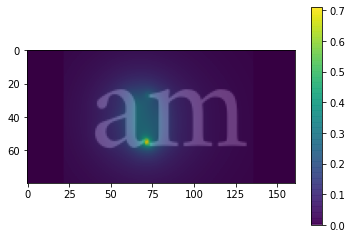

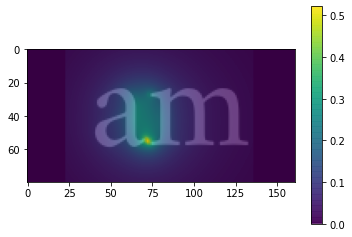

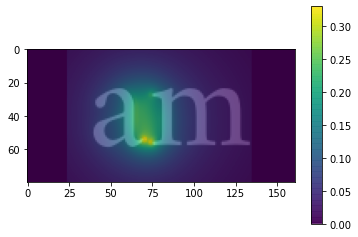

Grouping strength layer:
fullness exponents and coefficients:


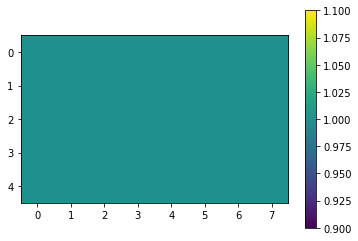

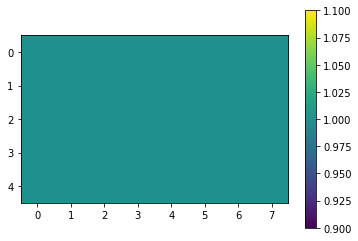

distance exponents and coefficients:


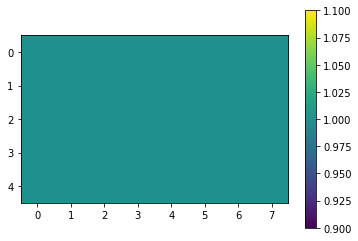

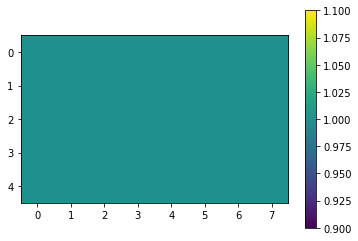

orientation_correlators:


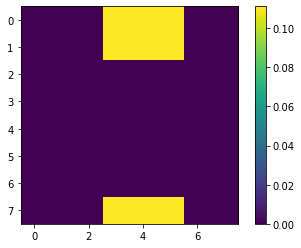

self a, self b: [1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.]
self e 0.5
Blurwidth: 0.5
Skeleton loss softmax n: -2.0
1/1 [==============================] - 6s 6s/step - loss: 0.0469


In [ ]:
# 5. Utility functions
eps = np.finfo(np.float32).tiny

def invspa(t):
    return np.log(np.exp(t) - 1).astype(np.float32)

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

# 6. Generating G-cell fragments

u, v = np.mgrid[-box_height/2:box_height/2,-box_width/2:box_width/2].astype(np.float32)
u = u / (box_width)
v = v / (box_width)
r = np.sqrt(u**2 + v**2)[None, None, None, None, :, :]

def make_losses_filters(g_spreads):
    return tf.exp(-r**2 / (2*g_spreads**2)) / (g_spreads * tf.math.sqrt(2.*3.14159276))

class GroupingStrengthLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(GroupingStrengthLayer, self).__init__(**kwargs)
        # Todo: we can try adding height here
        self.f_e = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="f_e",
                                 trainable=True)  
        self.f_a = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="f_a",
                                 trainable=True)  
        self.d_e = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="d_e",
                                 trainable=False)  
        self.d_a = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="d_a",
                                 trainable=True)

        self.a = self.add_weight(shape=(n_v1_scales),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="a",
                                 trainable=True)  
        self.b = self.add_weight(shape=(n_v1_scales),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="b",
                                 trainable=False)
        self.e = self.add_weight(shape=(),
                                 initializer=tf.keras.initializers.Constant(.5),
                                 name="e",
                                 trainable=False)

        a = np.zeros((2*n_v1_orientations, 2*n_v1_orientations)).astype(np.float32)
        for i in range(2*n_v1_orientations):
            for j in range(2*n_v1_orientations):
                a[i, j-4] = np.exp(-((np.abs(i - j) + 4) % 8 - 4) ** 2 / 2)
        
        a[:,:] = 0.0
        a[0:2, 3:6] = .1
        a[-1, 3:6] = .1

        self.orientation_correlators = self.add_weight(shape=(2*n_v1_orientations, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(a),
                                 dtype=tf.float32,
                                 name="orientation_correlators",
                                 trainable=True)  

        #self.distnet1 = tf.keras.layers.Dense(20, activation="elu")
        #self.distnet2 = tf.keras.layers.Dense(16, activation="elu")
        #self.distnet3 = tf.keras.layers.Dense(1, activation="sigmoid")

        #self.scale_indices = tf.tile(tf.range(n_v1_scales, dtype=tf.float32)[None, None, :, None, None, None], [batch_size, n_sample_distances, 1, 2*n_v1_orientations, box_height, box_width])

        #self.orientation_indices = tf.tile(tf.range(n_v1_orientations, dtype=tf.float32)[None, None, None, :, None, None], [batch_size, n_sample_distances, n_v1_scales, 2, box_height, box_width])

    def print_weights(self):
        print("fullness exponents and coefficients:")
        plt.imshow(tf.nn.relu(self.f_e))
        plt.colorbar()
        plt.show()
        plt.imshow(tf.nn.relu(self.f_a))
        plt.colorbar()
        plt.show()
        print("distance exponents and coefficients:")
        plt.imshow(tf.nn.relu(self.d_e))
        plt.colorbar()
        plt.show()
        plt.imshow(tf.nn.relu(self.d_a))
        plt.colorbar()
        plt.show()
        print("orientation_correlators:")
        plt.imshow(tf.nn.relu(self.orientation_correlators.numpy()) / tf.reduce_sum(self.orientation_correlators).numpy() )
        plt.colorbar()
        plt.show()
        print("self a, self b:", self.a.numpy(), self.b.numpy())
        print("self e", self.e.numpy())

    def call(self, inputs):
        (left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness) = inputs

        # Simplest model: a simple exponent / coefficient model, followed by a division.
        #i = eps + tf.nn.relu(inputs)
        #c = (eps + tf.nn.relu(self.coefficients))[None, None, :, :, None, None] / (eps + tf.reduce_mean(tf.nn.relu(self.coefficients)))
        #e = (eps + tf.nn.relu(self.exponents))[None, None, :, :, None, None]
        # cost = l * r / (l + r)

        # We want a somewhat more flexible model, which computes the cost at every location, based on the two strengthts.
        # The strengthnet accepts <b*d*s*o*h*w, 2+2> and outputs a single strength prediction <b*d*s*o*h*w, 1>

        # The default should be fullness / distance

        fl = (tf.nn.relu(left_v4_fullness) + eps) ** (eps + tf.nn.relu(self.f_e))[None, None, :, :, None, None] * tf.nn.relu(self.f_a)[None, None, :, :, None, None]
        fr = (tf.nn.relu(right_v4_fullness) + eps) ** (eps + tf.nn.relu(self.f_e))[None, None, :, :, None, None] * tf.nn.relu(self.f_a)[None, None, :, :, None, None]
        dl = (tf.nn.relu(left_v4_distance) + eps) ** (eps + tf.nn.relu(self.d_e))[None, None, :, :, None, None] * tf.nn.relu(self.d_a)[None, None, :, :, None, None]
        dr = (tf.nn.relu(right_v4_distance) + eps) ** (eps + tf.nn.relu(self.d_e))[None, None, :, :, None, None] * tf.nn.relu(self.d_a)[None, None, :, :, None, None]

        # Now we take these two strength values and we feed them through a network to estimate the damage from overlaying them.
        # Should we first add the numbers together? Two connections that are next to one another are probably handled differently from
        # two that are opposite one another.

        fullness_product = fl[:, :, :, :, None, :, :] * fr[:, :, :, None, :, :, :] # <bdsoqhw>
        fullness_product_damp = 1 / ((eps + tf.nn.relu(tf.reduce_sum(fullness_product, [3, 4])[:, :, :, None, :, :])) ** 0.5 + eps)

        dl_s = tf.tile(dl[:, :, :, :, None, :, :], [1, 1, 1, 1, 2 * n_v1_orientations, 1, 1]) + eps
        dr_s = tf.tile(dr[:, :, :, None, :, :, :], [1, 1, 1, 2 * n_v1_orientations, 1, 1, 1]) + eps
        #dl_sf, dr_sf = tf.reshape(dl_s, [-1]), tf.reshape(dr_s, [-1])

        d_diff = tf.abs(dl_s - dr_s) + eps
        d_sum = tf.nn.relu(dl_s + dr_s) / 2 + eps
        #d_input = tf.stack([tf.abs(dl_sf - dr_sf), (dl_sf + dr_sf) / 2], 1) # The smaller the initial values, the greater the output.
        #d_output = 1 - (eps + self.distnet3(self.distnet2(self.distnet1(d_input))))
        #distance_factor = tf.reshape(d_output, [batch_size, n_sample_distances, n_v1_scales, 2*n_v1_orientations, 2*n_v1_orientations, box_height, box_width])

        sl = fl[:, :, :, :, None, :, :] / dl_s
        sr = fr[:, :, :, None, :, :, :] / dr_s

        #distance_factor = tf.exp(-tf.nn.relu(self.a[None, None, :, None, None, None, None]) * d_diff / d_sum - tf.nn.relu(self.b[None, None, :, None, None, None, None]) * d_sum)
        #distance_factor =  tf.exp(-d_sum * tf.nn.relu(self.b[None, None, :, None, None, None, None]) + eps) / ( eps + (tf.nn.relu(self.a[None, None, :, None, None, None, None]) + eps + d_diff))   
        distance_factor = (tf.exp(-tf.nn.relu(d_diff)**2/(eps + tf.nn.relu(d_sum*.1*tf.nn.relu(self.a[None, None, :, None, None, None, None]))))
                            / (eps + tf.nn.relu(tf.nn.relu(self.b[None, None, :, None, None, None, None]) * d_sum))) # - 5*tf.nn.relu(d_sum))
        #distance_factor = tf.ones_like(distance_factor)
        # By default, we want opposite orientations to be weighted most strongly.
        # By default, we also want equal distances to be weigh more, and small distances to weigh more.

        # We want to have a value for each combination of orientations at every location.
        grouping_strength = (eps + tf.nn.relu(tf.einsum("bdsoqhw,bdsoqhw,oq->bdshw", fullness_product, distance_factor, tf.nn.relu(self.orientation_correlators) / (eps + tf.reduce_sum(self.orientation_correlators)))[:, :, 0:1, None, :, :])) * fullness_product_damp
        #grouping_strength = tf.einsum("bdsoqhw,oq->bdshw", distance_factor, tf.nn.relu(self.orientation_correlators) + eps)[:, :, 0:1, None, :, :]

        # We want the distance factor to decrease for larger distance pairs and to decrease for larger distance differences.
        # That is the opposite that we are seeing.
        grouping_strength = (tf.reduce_sum(sl, [3,4]) * tf.reduce_sum(sr, [3,4]) / (eps + tf.reduce_sum(sl + sr, [3, 4])))[:, :, 0:1, None, :, :]

        return grouping_strength


# 8. Cost layer
class SkeletonCostLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(SkeletonCostLayer, self).__init__(**kwargs)

        self.blurwidth = self.add_weight(shape=(),
                                 initializer=tf.keras.initializers.Constant(.5),
                                 name="blurwidths",
                                 trainable=True)  

        self.n = self.add_weight(shape=(),
                                 initializer=tf.keras.initializers.Constant(-2.),
                                 name="n",
                                 trainable=True)  

    def print_weights(self):
        print("Blurwidth:", self.blurwidth.numpy())
        print("Skeleton loss softmax n:", self.n.numpy())

    def call(self, inputs):
        #(l, r, p) = inputs

        # Find the skeleton losses
        #losses = tf.nn.relu(l - p) + tf.nn.relu(r - p)

        losses = inputs / 100000

        losses_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses, eps), [4, 5]))
        losses_filters = make_losses_filters(eps + tf.nn.relu(self.blurwidth) / 100.)
        losses_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses_filters, eps), [4, 5]))
        losses_filtered = (eps + tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(losses_fft * losses_filters_fft), [4, 5]))))

        #penalties = (tf.nn.relu(self.wk + eps) ** tf.range(n_v4_scales, dtype=tf.float32))[None, None, :, None, None]
        #penalties = tf.nn.relu(self.wp)[None, None, :, None, None]

        # Penalize the skeleton losses
        penalized_losses = losses #losses_filtered #* penalties 

        # Find the worst penalty
        pln = penalized_losses * 10 ** (self.n * 10)
        expd = tf.exp(pln - tf.reduce_max(pln, [2,3,4,5], keepdims=True))
        softmax_weights = expd / (eps + tf.reduce_sum(expd, axis=[2,3,4,5], keepdims=True))
        worst_skeleton_loss_penalty = penalized_losses * softmax_weights

        return penalized_losses #worst_skeleton_loss_penalty


# 8. Cost layer
class PenaltyLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)

        self.target = self.add_weight(shape=(),
                                 initializer=tf.keras.initializers.Constant(.85/1000.),
                                 name="target",
                                 trainable=False)  

    def print_weights(self):
        print("Target:", 1000*self.target.numpy())

    def call(self, inputs):
        skeleton_loss_cost = tf.reduce_max(tf.reduce_sum(inputs, [2], keepdims=True), [2,3,4,5])
        ys = (skeleton_loss_cost - self.target*1000) ** 2 / (eps + self.target*1000) ** .5
        return ys

# 9. Set up the actual math

def get_pair_violation_from_strength(left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness):
    # TODO: Give them each an exponent, weigh them by orientation and by scale, and sum them up.

    gsl = GroupingStrengthLayer()
    #left_strength = gsl(left_v4_strength)
    #right_strength = gsl(right_v4_strength)
    #total_strength_loss = tf.identity(left_strength * right_strength / (left_strength + right_strength), "strengthloss")

    total_strength_loss = gsl((left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness))

    sll = SkeletonCostLayer()
    skeleton_loss_cost_image = tf.identity(sll(total_strength_loss), "skeleton_loss_cost_image") # <b, d>
    #skeleton_loss_cost_image = tf.reduce_sum(total_strength_loss, [2,3], name="skeleton_loss_cost_image")

    #skeleton_loss_cost = tf.reduce_max(tf.reduce_sum(skeleton_loss_cost_image, [2], keepdims=True), [2,3,4,5])
    #ys = (skeleton_loss_cost - 500.) ** 2 # / (eps + tf.reduce_mean(skeleton_loss_cost)) #+ (grouping_strength - self.target_grouping) ** 2 + 
    pl = PenaltyLayer()
    ys = pl(skeleton_loss_cost_image)

    # Find worst violation of the well
    up_first_ness = (ys[:, 1] - ys[:, 0]) #[1,2,3,4,5,6]
    down_second_ness = (ys[:, 1] - ys[:, 2]) # has shape <batch_size>, [2,3,4,5,6,7,]
    worst_violation_sum = tf.reduce_mean((tf.reduce_max(tf.stack([up_first_ness, down_second_ness], axis=0), axis=[0]) + eps), name="worst_violation")
    return worst_violation_sum 

# 10. Set up Keras model and run

def get_keras_model():
    # The translated raw images aren't used in the model, they're just for visualization purposes ...
    left_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_image')
    right_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_image')

    # ... but the translated V1 responses are:
    left_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='left_v1_response', dtype=tf.complex64)
    right_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='right_v1_response', dtype=tf.complex64)
    left_v4_distance = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, 2*n_v1_orientations, box_height, box_width), name='left_v4_distance')
    right_v4_distance = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, 2*n_v1_orientations, box_height, box_width), name='right_v4_distance')
    left_v4_fullness = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, 2*n_v1_orientations, box_height, box_width), name='left_v4_fullness')
    right_v4_fullness = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, 2*n_v1_orientations, box_height, box_width), name='right_v4_fullness')

    # This calls the V4 layer, the penalty/reward layer, and finds the max cost
    #total_violation = tf.identity(get_pair_violation(left_v1_response, right_v1_response), "total_violation")
    total_violation = tf.identity(get_pair_violation_from_strength(left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness), "total_violation")

    return tf.keras.Model(inputs=[left_image, right_image, left_v4_distance, right_v4_distance, left_v4_fullness, right_v4_fullness, left_v1_response, right_v1_response], outputs=(total_violation))

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, interval):
        self.dataset = dataset
        self.interval = interval
        self.current_data = None

    def get_val(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])([self.current_data["left_v1_response"],
                                                                           self.current_data["right_v1_response"],
                                                                           self.current_data["left_v4_distance"],
                                                                           self.current_data["right_v4_distance"],
                                                                           self.current_data["left_v4_fullness"],
                                                                           self.current_data["right_v4_fullness"],
                                                                           self.current_data["left_image"],
                                                                           self.current_data["right_image"]])[0]
        return output

    def get_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        l.print_weights()

    def on_epoch_end(self, epoch, logs=None):
        # Only show this stuff every [interval] batches
        if epoch % self.interval != 0:
            return

        #print([l.name for l in self.model.layers])
        #print(self.model.inputs)

        self.current_data, _ = next(self.dataset) #list(self.dataset.take(1).as_numpy_iterator())[0]
        pair_images = self.current_data["left_image"] + self.current_data["right_image"]

        #print("\nPair DIFFS:")
        #pair_cost = self.get_val("pair_pixel_cost")
        #print("Pair total cost", self.get_val("pair_total_cost")[0, 0])
        #plt.imshow(pair_images[0, 0, :, :], alpha=1)
        #plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 0, 0, 0, 0, :, :], alpha=0.7)
        #plt.colorbar()
        #plt.show()
        #print("Pair total cost", self.get_val("pair_total_cost")[0, 1])
        #pair_cost = self.get_val("pair_pixel_cost")
        #plt.imshow(pair_images[0, 1, :, :], alpha=1)
        #plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 1, 0, 0, 0, :, :], alpha=0.7)
        #plt.colorbar()
        #plt.show()
        #print("Pair total cost", self.get_val("pair_total_cost")[0, 2])
        #pair_cost = self.get_val("pair_pixel_cost")
        #plt.imshow(pair_images[0, 2, :, :], alpha=1)
        #plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 2, 0, 0, 0, :, :], alpha=0.7)
        #plt.colorbar()
        #plt.show()

        # print("Grouping strengths:")
        # local_grouping_strengths = self.get_val("grouping_local_strengths")
        # for nb in range(n_sample_distances):
        #     plt.imshow(pair_images[0, nb, :, :], cmap="gray")
        #     plt.imshow(tf.reduce_sum(local_grouping_strengths[0, nb, :, :, :], [0]), alpha=.8)
        #     plt.colorbar()
        #     plt.show()

        print("Skeleton losses:")
        local_skeleton_loss_cost = self.get_val("skeleton_loss_cost_image")


        print("MAX IS", tf.reduce_max(tf.reduce_sum(local_skeleton_loss_cost, [2], keepdims=True), [2,3,4,5]).numpy())
        self.print_weights("penalty_layer")

        for nb in range(n_sample_distances):
            plt.imshow(pair_images[0, nb, :, :], cmap="gray")
            plt.imshow(tf.reduce_sum(local_skeleton_loss_cost[0, nb, :, :, :, :], [0, 1]), alpha=.8)
            plt.colorbar()
            plt.show()

        print("Grouping strength layer:")
        self.print_weights("grouping_strength_layer")
        self.print_weights("skeleton_cost_layer")

        return

        pair_diff = self.get_val("relevance")
        maxv = tf.reduce_max(pair_diff)
        minv = tf.reduce_min(pair_diff)
        ex = max(abs(maxv), abs(minv))
        fs = 16

        left_v4_response = self.get_val("left_v4_response")
        right_v4_response = self.get_val("right_v4_response")
        pair_v4_response = self.get_val("pair_v4_response")
        if True: # False if displaying B cells
            print("RAW LOSSES for size")
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 1, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(pair_diff[0, 1, 0, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            plt.show()
    
        if False:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 GAINS for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max loss:", tf.reduce_max(tf.nn.relu(pair_diff[0, 1, j, :, :])), "total losses:", tf.reduce_sum(tf.nn.relu(pair_diff[0, 1, j, :, :])))
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(tf.nn.relu(pair_diff[0, 1, j, :, :]), alpha=0.7)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(tf.nn.relu(pair_diff[0, 1, 0, :, :]), alpha=0.7)

            plt.show()


        # THIN SAMPLE RESULTS
        if True:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff*pair_v4_response)[0, 0, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * pair_v4_response)[0, 0, j, :, :])))
                    ax[j].imshow(pair_images[0, 0, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 0, j, :, :] * pair_v4_response[0, 0, j, :, :], alpha=0.7)
            else:
                ax.imshow(pair_images[0, 0, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 0, 0, :, :]), alpha=0.7)
            plt.show()


        if True:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff*pair_v4_response)[0, 1, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * pair_v4_response)[0, 1, j, :, :])))
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 1, j, :, :] * pair_v4_response[0, 1, j, :, :], alpha=0.7)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 1, 0, :, :]), alpha=0.7)
            plt.show()

        # WIDE SAMPLE RESULTS
        if True:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff * pair_v4_response)[0, 2, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * pair_v4_response)[0, 2, j, :, :])))
                    ax[j].imshow(pair_images[0, 2, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 2, j, :, :] * pair_v4_response[0, 2, j, :, :], alpha=0.7)
            else:
                ax.imshow(pair_images[0, 2, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 2, 0, :, :]), alpha=0.7)
            plt.show()

        if False:
            print("FILTERED")
            left_v4_filtered = self.get_val("left_v4_filtered")
            if True:
                figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
                fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
                print("RAW V4 PAIR TIMES RELEVANCE for size, without min/max limit")
                if n_v4_scales > 1:
                    for j in range(n_v4_scales):
                        print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu((pair_diff * left_v4_filtered)[0, 1, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu((pair_diff * left_v4_filtered)[0, 1, j, :, :])))
                        ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                        ax[j].imshow(left_v4_filtered[0, 1, j, :, :], alpha=0.7)
                else:
                    ax.imshow(pair_images[0, 1, :, :], alpha=1)
                    ax.imshow(tf.nn.relu(-pair_diff[0, 1, 0, :, :]), alpha=0.7)
                plt.show()
    

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("PAIR v4 response for size, without min/max limit, 0-3")
        if n_v4_scales > 1:
            for j in range(n_v4_scales):
                print("Channel", j, "max", tf.reduce_max(pair_v4_response[0, 1, j, :, :]), "sum", tf.reduce_sum(left_v4_response[0, 1,  j, :, :]))
                #print("Channel", j, "max", tf.reduce_max(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :]), "sum", tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :]))
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_v4_response[0, 1, j, :, :], alpha=0.8)
                #ax[j].imshow(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :], alpha=0.7)
        else:
            ax.imshow(pair_images[0, 1, :, :], alpha=1)
            ax.imshow(pair_v4_response[0, 1, 0, 0, 0, :, :], alpha=0.8)

        plt.show()

        if False:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("PAIR v4 response for size, without min/max limit, 0-3")
            for j in range(n_v4_scales):
                print("Channel", j, "max", tf.reduce_max(pair_v4_response[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(pair_v4_response[0, 1, 0, 0, j, :, :]))
                #print("Channel", j, "max", tf.reduce_max(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :]), "sum", tf.reduce_sum(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :]))
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_v4_response[0, 1, 0, 0, j, :, :], alpha=0.8)
                #ax[j].imshow(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :])
            plt.show()
    
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            maxv = tf.reduce_max(pair_cost)
            minv = tf.reduce_min(pair_cost)
            ex = max(abs(maxv), abs(minv))
            print("COST of DIFF for size")
            for j in range(n_v4_scales):
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_cost[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            plt.show()

        self.print_weights("v4_layer")

        self.print_weights("grouping_strength_layer")
        #self.print_weights("skeleton_cost_layer")
        self.print_weights("loss_layer")

        skeleton_loss_weight = 10 ** (self.get_weights("loss_layer")[2])
        grouping_strength = np.transpose(self.get_val("grouping_strengths"))

        target_strength = self.get_weights("loss_layer")[0]
        target_grouping = self.get_weights("loss_layer")[1]

        skeleton_loss_weights = np.transpose(skeleton_loss_weight * self.get_val("skeleton_losscosts"))
        print("Skeleton loss weight, extracted:", skeleton_loss_weight)
        #plt.plot(np.transpose((self.get_val("grouping_strengths") - 0.00023251) ** 2), ":") # Deviation penalties
        #plt.plot(np.transpose(skeleton_loss_weight * self.get_val("skeleton_losscosts")), "--")  # Skeleton loss penalties
        #plt.plot(np.transpose((self.get_val("grouping_strengths") - 0.00023251) ** 2) + skeleton_loss_weight * np.transpose(self.get_val("skeleton_losscosts"))) # Total penalties
        #plt.plot(skeleton_loss_weights, "--")
        #plt.plot(-grouping_strength, ":")
        #plt.plot(skeleton_loss_weights - grouping_strength)        
        plt.plot(np.transpose(self.get_val("skeleton_losscosts") - target_strength)**2) # + (grouping_strength - target_grouping) ** 2)
        plt.show()


        #ys = (tf.reduce_max(self.skeleton_loss_cost, [2,3,4]) - self.target_strength) ** 2
    


model = get_keras_model()
testing = 1
model.compile(loss=(lambda _, c: c), optimizer=tf.keras.optimizers.Adam(0.0 if testing else .0001))


prepared_dataset = translated_dataset.shuffle(30*batch_size).batch(batch_size).prefetch(batch_size)

if True:
    history = model.fit(prepared_dataset,
                        callbacks=[MonitorProgressCallback(prepared_dataset.as_numpy_iterator(), 1 if testing else 22)],
                        epochs=(1 if testing else 1000),
                        steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)

loss_penalty tf.Tensor(0.93723756, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(1.5318897, shape=(), dtype=float32)
loss_penalty tf.Tensor(1.1858652, shape=(), dtype=float32) for distance 1.0 thanks to value tf.Tensor(1.4110256, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.06913991, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(2.2370553, shape=(), dtype=float32)
loss_penalty tf.Tensor(5.653982, shape=(), dtype=float32) for distance -4.2360680251559995 thanks to value tf.Tensor(4.8778105, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.06913991, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(2.2370553, shape=(), dtype=float32)
loss_penalty tf.Tensor(1.8811307, shape=(), dtype=float32) for distance -2.6180339844527367 thanks to value tf.Tensor(3.8715432, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.06913991, shape=(), dtype=float32) for distance -1.000000025156 thanks to value tf.Tensor(2.2370553, 

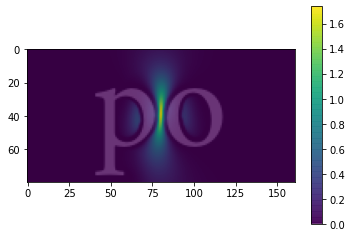

loss_penalty tf.Tensor(0.58109415, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(1.7377046, shape=(), dtype=float32)


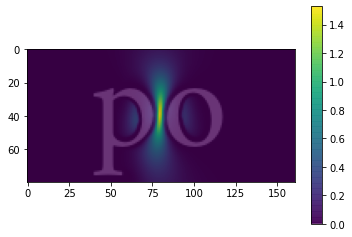

loss_penalty tf.Tensor(0.94391817, shape=(), dtype=float32) for distance 1.0 thanks to value tf.Tensor(1.5284455, shape=(), dtype=float32)


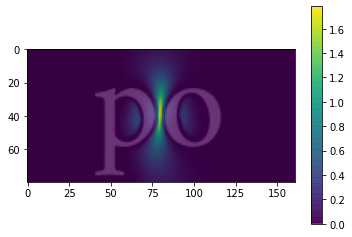

loss_penalty tf.Tensor(0.5135431, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(1.7833807, shape=(), dtype=float32)


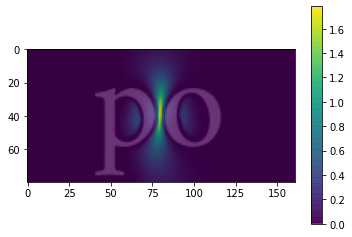

loss_penalty tf.Tensor(0.5135431, shape=(), dtype=float32) for distance tf.Tensor(-0.9792261, shape=(), dtype=float32) thanks to value tf.Tensor(1.7833807, shape=(), dtype=float32)


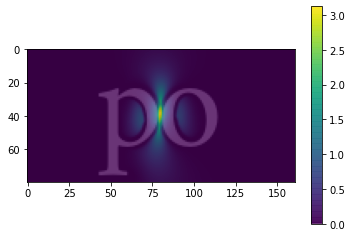

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance -4.2360680251559995 thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


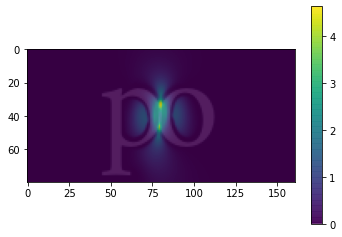

loss_penalty tf.Tensor(4.575198, shape=(), dtype=float32) for distance -8.472136091015262 thanks to value tf.Tensor(4.6389713, shape=(), dtype=float32)


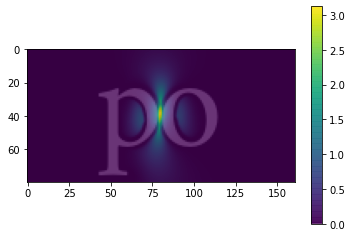

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance -4.2360680251559995 thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


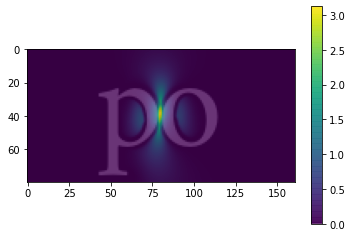

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance -5.854101999999998 thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


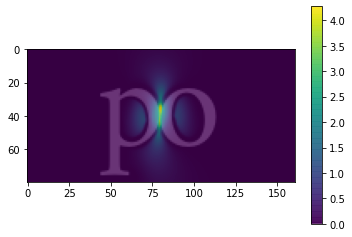

loss_penalty tf.Tensor(3.1514988, shape=(), dtype=float32) for distance -6.854102009608734 thanks to value tf.Tensor(4.275246, shape=(), dtype=float32)


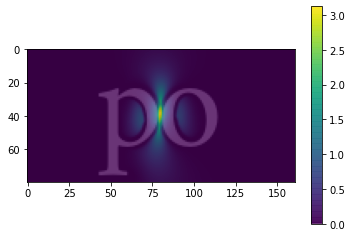

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.045085, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


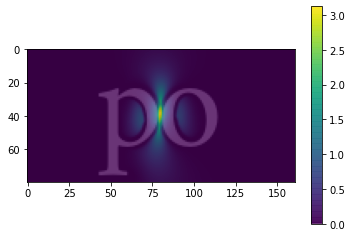

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.354102, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


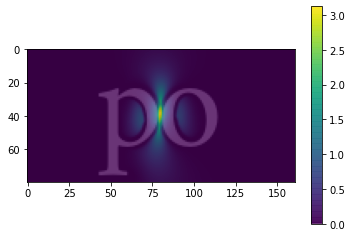

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.545085, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


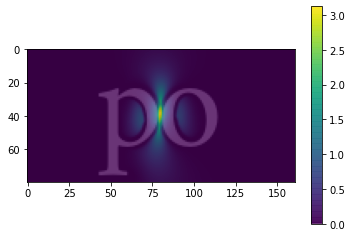

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.663119, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


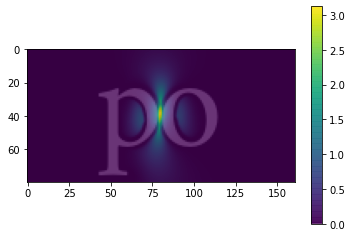

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.736068, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


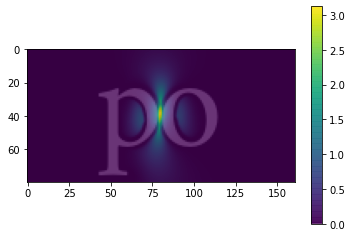

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.7811527, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


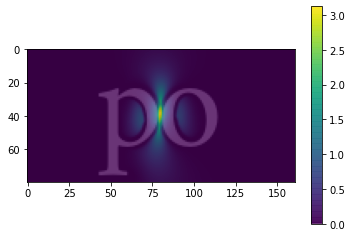

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.8090167, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)


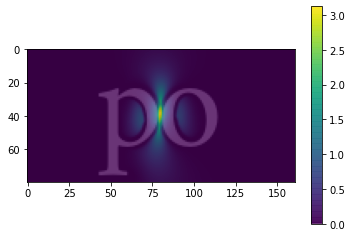

loss_penalty tf.Tensor(0.38898015, shape=(), dtype=float32) for distance tf.Tensor(-5.8262377, shape=(), dtype=float32) thanks to value tf.Tensor(3.1236827, shape=(), dtype=float32)
Best distance for p o : tf.Tensor(-5.8262377, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181414, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(2.3896306, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.10167949, shape=(), dtype=float32) for distance 1.0 thanks to value tf.Tensor(2.1811278, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.15647112, shape=(), dtype=float32) for distance -1.618034 thanks to value tf.Tensor(2.8955643, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181414, shape=(), dtype=float32) for distance 0.0 thanks to value tf.Tensor(2.3896306, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181414, shape=(), dtype=float32) for distance -0.618033974844 thanks to value tf.Tensor(2.3896306, shape=(), dtype=float32)
loss_penalty tf.Tensor(0.012181

In [ ]:
# PARAMETERS

kk = 2.8
cp = 0.2
cn = 0.25
v1_v4_scale_weights = tf.tile(tf.constant([.04, .1, .13, .04, .01])[:, None], [1, n_v4_scales]) # includes the CSF
v1_v4_scale_weights = tf.ones((n_v1_scales, n_v4_scales)) # An alternative for the CSF.
v1_v4_orientation_weights = tf.ones((2*n_v1_orientations, n_v4_scales))

k = tf.constant([2.4] * n_v4_scales)
b = (0.7 ** (2.4 * tf.range(n_v4_scales, dtype=tf.float32)))

# Skeleton loss penalty
blurwidths = 0.5 / 100.
n = -.2
loss_penalties = tf.constant([0.5, 1.6, 1.5, 0.37, 0.1, 0.01, 0.01, 0.01])
skeleton_loss_target = 2.5

f_e = tf.constant([0.95, 1.0, 1.2, 0.95, 0.95, 1., 1.1, 1.0])[None, :, None, None]
f_a = tf.constant([0.95, 1.0, 1.2, 0.95, 0.95, 1., 1.1, 1.0])[None, :, None, None]
d_e = tf.constant([1., 1., 1., 1., 1., 1., 1., 1.])[None, :, None, None]
d_a = tf.constant([1.025, 1.01, 0.8, 0.925, 1., 0.97, 0.875, 0.93])[None, :, None, None]

orientation_correlators = np.zeros((8, 8)).astype(np.float32)
orientation_correlators[7,2:5] = 0.125
orientation_correlators[7,5] = 0.2
orientation_correlators[0,2] = 0.075
orientation_correlators[0,3:5] = 0.05
orientation_correlators[1,2:5] = 0.05
orientation_correlators[1,5] = 0.15
orientation_correlators[2,4:7] = 0.1
#orientation_correlators[4,0] = 0

def pair_at_distance(d, l, r):
    (lt, rt) = get_pair_translations(l, r, d)
    #v1_l = translate_4d_image(glyph_v1_responses[l], np.array([lt]))[0, ...]
    #v1_r = translate_4d_image(glyph_v1_responses[r], np.array([rt]))[0, ...]
    v4d_l = translate_4d_image(glyph_v4_distances[l], np.array([lt]))[0, ...]
    v4d_r = translate_4d_image(glyph_v4_distances[r], np.array([rt]))[0, ...]
    v4f_l = translate_4d_image(glyph_v4_fullnesses[l], np.array([lt]))[0, ...]  # <s, o, h, w>
    v4f_r = translate_4d_image(glyph_v4_fullnesses[r], np.array([rt]))[0, ...]
    g_l = translate_4d_image(glyph_images[l][None, None, :, :], np.array([lt]))[0, 0, 0, :, :]
    g_r = translate_4d_image(glyph_images[r][None, None, :, :], np.array([rt]))[0, 0, 0, :, :]
    #v1_p = v1_l + v1_r
    #v1c_l, v1c_r, v1c_p = tf.abs(v1_l), tf.abs(v1_r), tf.abs(v1_p)
    #v4g_l, v4g_r, v4g_p = g_response(v1c_l), g_response(v1c_r), g_response(v1c_p)

    fl = (tf.nn.relu(v4f_l) + eps) ** f_e * f_a
    fr = (tf.nn.relu(v4f_r) + eps) ** f_e * f_a
    dl = (tf.nn.relu(v4d_l) + eps) ** d_e * d_a
    dr = (tf.nn.relu(v4d_r) + eps) ** d_e * d_a

    fullness_product = fl[:, :, None, :, :] * fr[:, None, :, :, :]
    dl_s = tf.tile(dl[:, :, None, :, :], [1, 1, 2 * n_v1_orientations, 1, 1])
    dr_s = tf.tile(dr[:, None, :, :, :], [1, 2 * n_v1_orientations, 1, 1, 1])

    d_diff = tf.abs(dl_s - dr_s) + eps
    d_sum = (tf.nn.relu(dl_s + dr_s) + eps) / 2

    distance_factor = tf.exp(-d_diff**2/(eps+.1*d_sum)) / (eps + d_sum)

    losses = tf.einsum("soqhw,soqhw,oq->shw", fullness_product, distance_factor, orientation_correlators / tf.reduce_sum(orientation_correlators))[0:1, None, :, :] / 100000

    if True:
        losses_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses, 0.), [2, 3]))
        losses_filters = make_losses_filters(eps + blurwidths)[0, 0, ...]
        losses_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(losses_filters, eps), [2, 3]))
        losses_filtered = losses #tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(losses_fft * losses_filters_fft), [2, 3]))

    if False: 
        pln = losses_filtered * 10 ** (n * 10)
        expd = tf.exp(pln - tf.reduce_max(pln, [2,3], keepdims=True))
        softmax_weights = expd / (eps + tf.reduce_sum(expd, axis=[2,3], keepdims=True))
        worst_skeleton_loss_penalty = losses_filtered * softmax_weights
    
        #loss_penalty = (tf.reduce_sum(worst_skeleton_loss_penalty) - 60) ** 2
    loss_penalty = (tf.reduce_max(losses_filtered[0:1, 0, :, :]) - 2.5) ** 2
    if (l == "p") and True:
        #print(tf.reduce_max(losses_filtered[0:1, 0, :, :]))
        plt.imshow(g_l + g_r, cmap="gray")
        #plt.imshow(worst_skeleton_loss_penalty[0, 0, :, :], alpha=0.8)
        plt.imshow(losses_filtered[0, 0, :, :], alpha=0.8)
        #plt.imshow(losses[0, 0, :, :], alpha=0.8)
        plt.colorbar()
        plt.show()

#    relevance = 1. - (tf.abs(v4g_l - v4g_r)/(eps + v4g_l + v4g_r)) ** 1.3
#
#    attention_attraction_rates = v4g_p * channel_attention_attraction_rate * relevance * yfn / (eps + tf.reduce_min(channel_attention_attraction_rate))
#
#    attention_attraction_pool_local = tf.einsum("chw,qc->qhw", attention_attraction_rates ** g, w_local)
#    attention_attraction_pool_global = tf.einsum("chw,qc->q", attention_attraction_rates ** g, w_global)[:, None, None]
#    probability_of_grouping_feedback = attention_attraction_rates ** g / (beta ** g + attention_attraction_pool_local + attention_attraction_pool_global)
#    
#    feedback_strength = v4g_p ** fk * fb
#
#    mean_grouping_strength = tf.reduce_sum(probability_of_grouping_feedback * feedback_strength)
    print("loss_penalty", loss_penalty, "for distance", d, "thanks to value", tf.reduce_max(losses_filtered[0:1, 0, :, :]))
    return loss_penalty

def find_best_distance(l, r):
    best_distance = minimize_scalar(pair_at_distance, args=(l, r), options={"maxiter": 10}).x

    print("Best distance for", l, r, ":", best_distance)


if False:
    find_best_distance("N", "N")
    find_best_distance("L", "T")
    find_best_distance("N", "T")
    find_best_distance("O", "T")
    find_best_distance("R", "S")
    find_best_distance("C", "X")
else:
    find_best_distance("l", "l")
    find_best_distance("p", "o")
    find_best_distance("d", "b")
    find_best_distance("d", "h")
    find_best_distance("m", "i")
    find_best_distance("a", "a")
